# Librerias y funciones auxiliares

In [1]:
# !pip install pandas
# !pip install nltk
# !pip install scikit-learn==1.4.2
# !pip install tqdm
# !pip install matplotlib
# !pip install neattext
# !pip install emoji
# !pip install deep-translator

In [2]:
# Importar csv y tratar con el dataset
import pandas as pd
# NLP
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('word2vec_sample')
# Eliminar warning del replace
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# from enum import Enum
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
# Graficar
import matplotlib.pyplot as plt
# Guardado e importacion
import joblib
# Traducir
# from googletrans import Translator
# Progreso
from tqdm import tqdm

#------------------FUNCIONES------------------#

# Funcion axuiliar para saber si estoy en el collab y usar su path o el del proyecto de github
def is_running_on_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

from enum import Enum
# Funcion auxiliar para luego entrenar varios modelos con una sola ejecucion
class Modelos(Enum):
    LOGISTIC_REGRESSION = 'logistic_regression'
    DECISION_TREE = 'decision_tree'
    MULTINOMIAL = 'multinomial'
    BERNOULLI = 'bernoulli'
    GAUSIAN = 'gausian'

#------------------FUNCIONES------------------#

def select_model_to_train(model_name):
    models = {
        Modelos.LOGISTIC_REGRESSION.value: LogisticRegression(max_iter=1000),
        Modelos.DECISION_TREE.value : DecisionTreeClassifier(),
        Modelos.MULTINOMIAL.value : MultinomialNB(),
        Modelos.BERNOULLI.value: BernoulliNB(),
        Modelos.GAUSIAN.value: GaussianNB()
    }
    if model_name in models:
        return models[model_name]
    else:
        raise ValueError(f"Modelo '{model_name}' no válido")


def show_dataset_info(df, nombre_columna):
    print("Cantidad de registros:")
    print(len(df))

    print("Contenido:")
    print(df.head())

    conteo_valores = df[nombre_columna].value_counts()
    porcentaje_valores = conteo_valores / len(df) * 100


    for index, value in enumerate(conteo_valores):
        porcentaje = porcentaje_valores.iloc[index]
        plt.text(index, value + 0.5, '{} ({:.2f}%)'.format(value, porcentaje), ha='center')


    conteo_valores.plot(kind='bar')
    plt.tight_layout()
    plt.xlabel('Valores Clasificaicon')
    plt.ylabel('Cant Valores')
    plt.title('Distribución de valores en la columna ' + nombre_columna)
    plt.show()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\victor\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\victor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\victor\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\victor\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\victor\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package word2vec_sample to
[nltk_data]     C:\Users\victor\AppData\Roaming\nltk_data...
[nltk_data]   Package word2vec_sample is alrea

# Funcion procesador texto

In [3]:
import neattext.functions as nfx
from nltk import pos_tag, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
import emoji

wnl = WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'


stopwords_en = stopwords.words('english')
stopwords_en = set(stopwords_en).union(set(punctuation))

my_custom_stopwords = {'’', "n't", "'m", "'s", "'ve", '...', 'ca', "''", '``', '\u200d', 'im', 'na', "'ll", '..', 'u', "'re", "'d", '--', '”', '“', '\u200f\u200f\u200e', '....', 'ㅤ','\u200e\u200f\u200f\u200e', 'x200b', 'ive', '.-', '\u200e', '‘'}

stopwords_en = stopwords_en.union(my_custom_stopwords)


def preprocessing_function(text):
    words = []

    for word, tag in pos_tag(word_tokenize(nfx.clean_text(text))):
        word_lemmatized = wnl.lemmatize(word.lower(), pos=penn2morphy(tag))

        if '\u200b' in word_lemmatized:
            continue

        if word_lemmatized not in stopwords_en and not word_lemmatized.isdigit() and not emoji.purely_emoji(word_lemmatized):
            words.append(word_lemmatized)

    return words

# Entrenamiento

# Balanceamos manualmente el dataset

Como el dataset original tenia demasiadas filas decidimos quedarnos con 50mil como hicimos con el modelo de suicidio, el problema es que al tomar las primeras 50mil filas el dataset resultante queda desbalanceado asi que fuimos recorriendolo hasta generar 25k filas de True y 25k filas de False, guardando un nuevo .csv

In [4]:
import pandas as pd

def build_balanced_dataset(
    rows: int,
    path: str, 
    label_a: int, 
    label_b: int, 
    column_target: str
):
    counter_label_a = 0
    counter_label_b = 0

    df = pd.read_csv(path, nrows=180000)
    try:
        df = df.drop(columns=['Content_int'])
    except:
        pass

    selected_rows = []

    for _, row in df.iterrows():
        if row[column_target] == label_a and counter_label_a < rows/2:
            counter_label_a += 1
            selected_rows.append(row)
        if row[column_target] == label_b and counter_label_b < rows/2:
            counter_label_b += 1
            selected_rows.append(row)
    
    df = None

    if(len(selected_rows) == 0):
        raise ValueError("No se encontraron registros con los labels indicados")
    else:
        new_df = pd.DataFrame(selected_rows)
        new_path = path.replace('.csv', '_MODIFICADO.csv')
        new_df.to_csv(new_path, index=False)

In [5]:
# Indicamos la cantidad que necesitamos para nuestro dataset, el path del dataset original, las etiquetas que queremos balancear y el nombre de la columna target
build_balanced_dataset(50000, '..\\datasets\\HateSpeechDataset.csv', 1, 0, 'Label')

## Importacion dataset

In [6]:
# MODIFICAR ESTOS PARAMETROS PARA LA IMPORTACION
# --------------------------------------------------------
usar_dataset_local = True
cant_importada = 50000
path_base_dataset = '/content/' if is_running_on_colab() else '..\\datasets\\'
# PARAL LOCAL
nombre_archivo_dataset = 'HateSpeechDataset_MODIFICADO.csv'
# AMBOS
columna_texto = 'Content'
columna_clasificacion = 'Label'
# --------------------------------------------------------


path_dataset =  path_base_dataset + nombre_archivo_dataset
dataframe = pd.read_csv(path_dataset, nrows=cant_importada)

Cantidad de registros:
50000
Contenido:
                                             Content  Label
0  denial of normal the con be asked to comment o...      1
1  just by being able to tweet this insufferable ...      1
2  that is retarded you too cute to be single tha...      1
3  thought of a real badass mongol style declarat...      1
4                                afro american basho      1


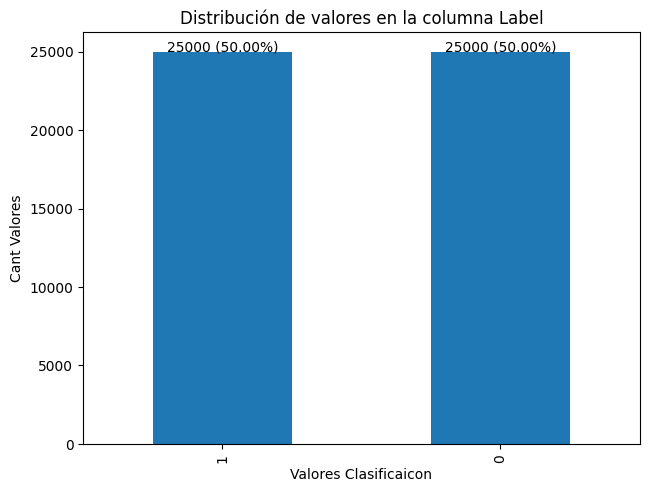

In [7]:
# Colocar el nombre de la columna para ver la distribucion de datos
show_dataset_info(dataframe, columna_clasificacion)

In [8]:
# Paso a booleano la clasificacion
dataframe[columna_clasificacion] = dataframe[columna_clasificacion].replace({1: True, 0: False})
dataframe[columna_clasificacion].value_counts()

Label
True     25000
False    25000
Name: count, dtype: int64

## Ajuste y guardado

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(dataframe[columna_texto],
                                                    dataframe[columna_clasificacion],
                                                    test_size=0.20, random_state=0)

count_vectorizer = CountVectorizer(analyzer=preprocessing_function, binary=True)

X_train_vectorized = count_vectorizer.fit_transform(X_train)
X_test_vectorized = count_vectorizer.transform(X_test)

## Funcion entrenar modelo y ver metrica

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import time


def test(clf, nombreModelo):
  start_time = time.time()

  clf.fit(X_train_vectorized.toarray(), y_train)
  y_pred = clf.predict(X_test_vectorized.toarray())

  accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
  precision = precision_score(y_true=y_test, y_pred=y_pred, average='weighted')
  recall = recall_score(y_true=y_test, y_pred=y_pred, average='weighted')
  f1 = f1_score(y_true=y_test, y_pred=y_pred, average='weighted')

  end_time = time.time()
  execution_time = end_time - start_time

  if execution_time > 60:
    execution_time_str = "{:.2f} minutes".format(execution_time / 60)
  else:
    execution_time_str = "{:.2f} seconds".format(execution_time)

  print("Datos de la ejecución para: " + nombreModelo)
  print(f"Accuracy: {accuracy:.2f}")
  print(f"Precision: {precision:.2f}")
  print(f"Recall: {recall:.2f}")
  print(f"F1 Score: {f1:.2f}")
  print("\nClassification Report:\n", classification_report(y_test, y_pred))
  print(f"Tiempo de ejecución para {nombreModelo}: {execution_time_str}")

  disp = ConfusionMatrixDisplay.from_estimator(
        clf, X_test_vectorized.toarray(), y_test,  xticks_rotation="vertical"
   )

  plt.title(nombreModelo + " - Accuracy: {:.2f}".format(accuracy))

  # disp.plot()
  plt.show()

  return disp


--------------------------------
Datos de la ejecución para: multinomial
Accuracy: 0.74
Precision: 0.74
Recall: 0.74
F1 Score: 0.74

Classification Report:
               precision    recall  f1-score   support

       False       0.74      0.73      0.74      4971
        True       0.74      0.75      0.74      5029

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000

Tiempo de ejecución para multinomial: 13.26 seconds


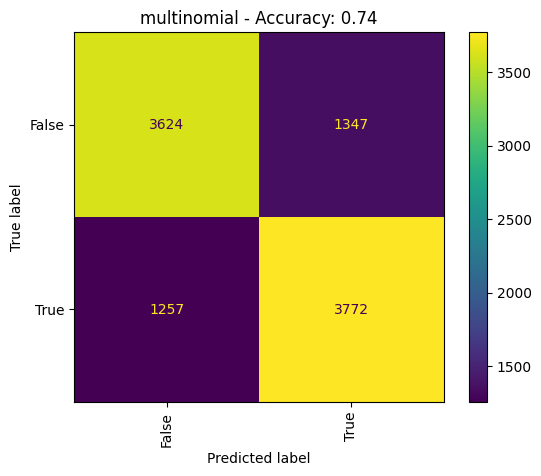

--------------------------------


--------------------------------
Datos de la ejecución para: bernoulli
Accuracy: 0.73
Precision: 0.73
Recall: 0.73
F1 Score: 0.73

Classification Report:
               precision    recall  f1-score   support

       False       0.74      0.71      0.73      4971
        True       0.73      0.76      0.74      5029

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000

Tiempo de ejecución para bernoulli: 17.66 seconds


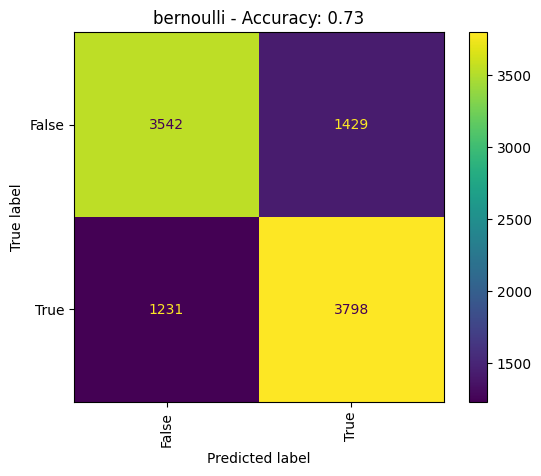

--------------------------------


--------------------------------
Datos de la ejecución para: gausian
Accuracy: 0.55
Precision: 0.59
Recall: 0.55
F1 Score: 0.48

Classification Report:
               precision    recall  f1-score   support

       False       0.65      0.19      0.29      4971
        True       0.53      0.90      0.67      5029

    accuracy                           0.55     10000
   macro avg       0.59      0.54      0.48     10000
weighted avg       0.59      0.55      0.48     10000

Tiempo de ejecución para gausian: 14.00 seconds


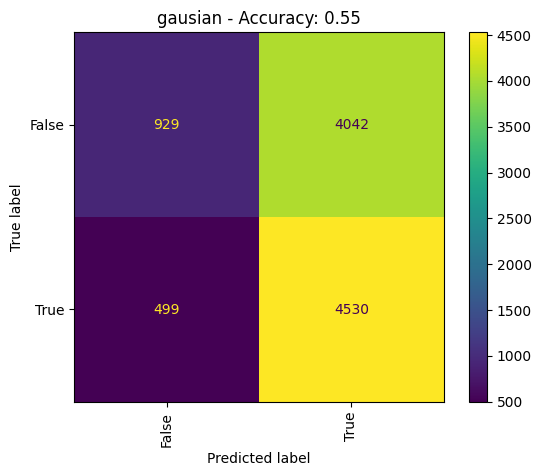

--------------------------------


--------------------------------
Datos de la ejecución para: logistic_regression
Accuracy: 0.77
Precision: 0.77
Recall: 0.77
F1 Score: 0.76

Classification Report:
               precision    recall  f1-score   support

       False       0.74      0.82      0.78      4971
        True       0.80      0.71      0.75      5029

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.76     10000
weighted avg       0.77      0.77      0.76     10000

Tiempo de ejecución para logistic_regression: 29.11 seconds


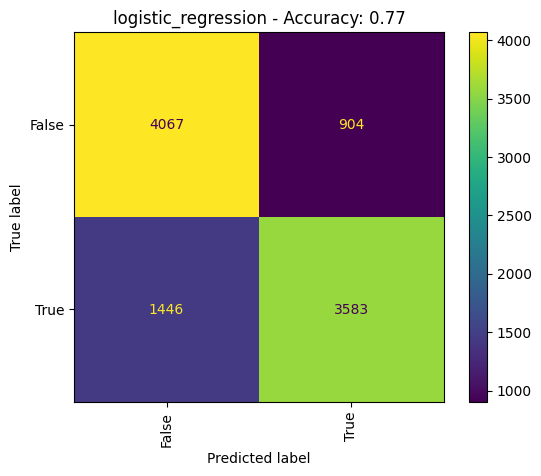

--------------------------------


--------------------------------
Datos de la ejecución para: decision_tree
Accuracy: 0.72
Precision: 0.72
Recall: 0.72
F1 Score: 0.72

Classification Report:
               precision    recall  f1-score   support

       False       0.71      0.74      0.72      4971
        True       0.73      0.70      0.71      5029

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000

Tiempo de ejecución para decision_tree: 21.16 minutes


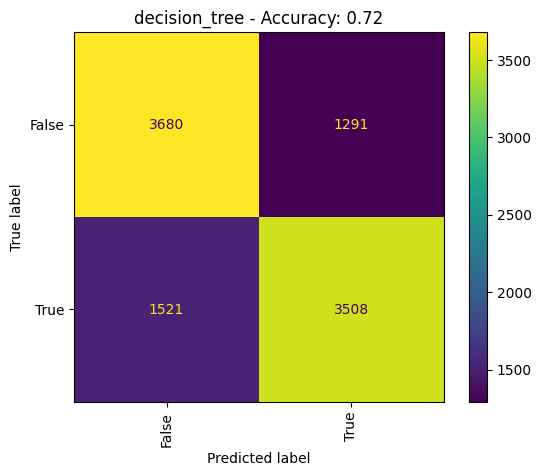

--------------------------------



In [11]:
# MODIFICAR ESTOS PARAMETROS PARA EL GUARDADO
# --------------------------------------------------------
# Colocar en true el modelo que se desea entrenar
modelos_disponibles = {
    Modelos.MULTINOMIAL.value: True,
    Modelos.BERNOULLI.value: True,
    Modelos.GAUSIAN.value: True,
    Modelos.LOGISTIC_REGRESSION.value : True,
    Modelos.DECISION_TREE.value: True,
}
path_base_modelo = '/content/' if is_running_on_colab() else '..\\entrenados\\'
# --------------------------------------------------------

cant_entrenada_str = "{:.0f}".format(cant_importada/1000) + 'k'

for nombreModelo, entrenar in modelos_disponibles.items():
    if entrenar:
        print("\n--------------------------------")
        modelToTrain = select_model_to_train(nombreModelo)
        test(modelToTrain, nombreModelo)

        path_modelo = path_base_modelo + nombreModelo + '_' + cant_entrenada_str
        joblib.dump(modelToTrain, path_modelo +  '_model.pkl')
        joblib.dump(count_vectorizer, path_modelo + '_vector.pkl')
        modelToTrain = None
    else:
        print(f"Modelo {nombreModelo} no entrenado")
    print("--------------------------------\n")

# Casos de uso

## Cargar modelo previamente generado

EJECUTAR PREVIAMENTE Funcion procesador texto

In [12]:
# MODIFICAR ESTOS PARAMETROS PARA LA CARGA
# --------------------------------------------------------
nombre_modelo_prev_entrenado = Modelos.LOGISTIC_REGRESSION.value
# usar formato '25k' para 25.000 filas ejemplo
cant_prev_entrenada = '50k'

path_base_modelo_generado = '/content/' if is_running_on_colab() else '..\\entrenados\\'
path_modelo_generado = path_base_modelo_generado + nombre_modelo_prev_entrenado + '_' + cant_prev_entrenada
# --------------------------------------------------------

model = joblib.load(path_modelo_generado + '_model.pkl')
vect = joblib.load(path_modelo_generado + '_vector.pkl')

print(type(vect))
print(type(model))

<class 'sklearn.feature_extraction.text.CountVectorizer'>
<class 'sklearn.linear_model._logistic.LogisticRegression'>


# Funcion predict

In [13]:
def get_texto_con_violencia(text_input):
    texto_a_analizar = text_input

    texto_preprocesado = ' '.join(preprocessing_function(texto_a_analizar))
    texto_vectorizado = vect.transform([texto_preprocesado])

    return bool(model.predict(texto_vectorizado)[0])

# Funcion para traduccion

In [14]:
from deep_translator import GoogleTranslator

def translatedSentence(text):
    return GoogleTranslator(source='auto', target='en').translate(text=text)

## Probar con datos de un dataset

Cantidad de registros:
50000
Contenido:
                                             Content  Label  \
0  retweet trees you need a black hoe who cheatin...      0   
1     retweet that outside penis keep them hoes sick      0   
2  retweet team no hoes face with tears of joy ok...      0   
3                        retweet got all the bitches      0   
4  retweet anything said about my moms b would ha...      0   

                                         Content_int  
0  [146715, 1761, 9167, 26, 188, 24, 1071, 9695, ...  
1  [146715, 1761, 28, 1706, 8791, 529, 610, 1339,...  
2  [146715, 1761, 840, 385, 1339, 608, 89, 2496, ...  
3          [146715, 1761, 113, 298, 3, 9693, 146714]  
4  [146715, 1761, 733, 155, 150, 129, 3743, 431, ...  


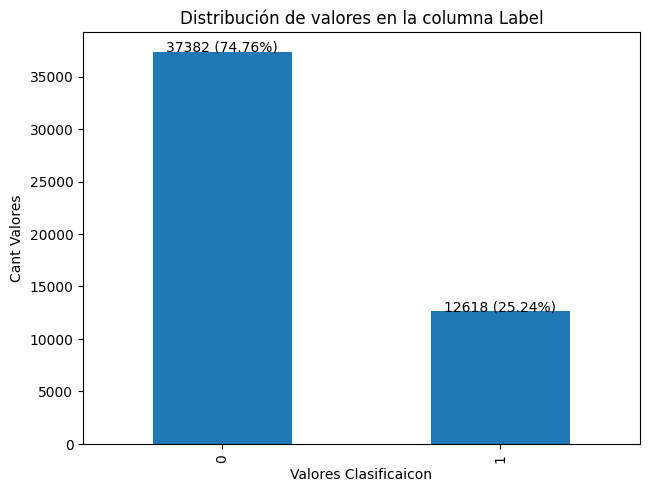

In [19]:

# MODIFICAR ESTOS PARAMETROS PARA LA CARGA
# --------------------------------------------------------
# 0 si se quiere arrancar desde el principio
nro_fila_arranque = 100000

cant_a_probar = 50000

path_base_dataset_test = '/content/' if is_running_on_colab() else '..\\datasets\\'

nombre_archivo_dataset_test = 'HateSpeechDataset.csv'
columna_texto_test = 'Content'
columna_clasificacion_test = 'Label'
clasificacion_true_test = '1'
clasificacion_false_test = '0'
# --------------------------------------------------------

path_dataset =  path_base_dataset_test + nombre_archivo_dataset_test
dataframeTest = pd.read_csv(path_dataset, skiprows=nro_fila_arranque, nrows=cant_a_probar)

columnas_renombradas = {columna_texto_test: 'text', columna_clasificacion_test: 'class'}

if nro_fila_arranque != 0:
    dataframeColumns = pd.read_csv(path_dataset, nrows=1).columns
    dataframeTest.columns = dataframeColumns

show_dataset_info(dataframeTest, columna_clasificacion_test)

In [20]:

counter = 0

for index, row in tqdm(dataframeTest.iterrows(), total=len(dataframeTest)):
    clasificacion_test = True if row[columna_clasificacion_test] == clasificacion_true_test else False

    prediccion = get_texto_con_violencia(text_input=row[columna_texto_test])

    if prediccion != clasificacion_test:
        counter = counter + 1

print("La cantidad de casos donde no coincidio la prediccion con la clasificacion real del dataset: " + str(counter) + " - " + str("{:.2f} %".format(cant_a_probar / counter) if counter != 0 else "no hubo errores"))


100%|██████████| 50000/50000 [01:16<00:00, 657.37it/s]

La cantidad de casos donde no coincidio la prediccion con la clasificacion real del dataset: 14173 - 3.53 %


## Probar con nuestros ejemplos

In [23]:
import neattext as nt

textos_prueba = [
    "Quiero que te mueras.",
    "Eres una basura humana.",
    "Ojalá te pase algo malo.",
    "Odio a todos los que me rodean.",
    "Desaparece de mi vida.",
    "Te voy a hacer daño.",
    "Eres la peor persona del mundo.",
    "No mereces vivir.",
    "Te detesto con todas mis fuerzas.",
    "Ojalá nunca hubieras nacido.",
                 ]

for texto in textos_prueba:
    prediccion = get_texto_con_violencia(translatedSentence(texto))

    print(texto)
    print('{0: <30}'.format('Prediccion') + ': ' + ('Violento' if prediccion else 'No es violento'))
    print('------------------------------------------------------------------------------------------------------')


Quiero que te mueras.
Prediccion                    : No es violento
------------------------------------------------------------------------------------------------------
Eres una basura humana.
Prediccion                    : Violento
------------------------------------------------------------------------------------------------------
Ojalá te pase algo malo.
Prediccion                    : No es violento
------------------------------------------------------------------------------------------------------
Odio a todos los que me rodean.
Prediccion                    : No es violento
------------------------------------------------------------------------------------------------------
Desaparece de mi vida.
Prediccion                    : No es violento
------------------------------------------------------------------------------------------------------
Te voy a hacer daño.
Prediccion                    : No es violento
--------------------------------------------------------------

# Palabras mas comunes segun nuestra funcion analizadora

In [31]:
from collections import Counter

word_counts = Counter()

for row in tqdm(dataframe.iterrows(), total=len(dataframe)):
    text = row[1].iat[0]
    for word in preprocessing_function(text):
        word_counts[word] += 1

print(len(word_counts))
print(word_counts.most_common(25))

100%|██████████| 50000/50000 [00:31<00:00, 1590.34it/s]

24565
[('like', 4667), ('people', 4659), ('bitch', 3871), ('fuck', 3787), ('slut', 3434), ('face', 2865), ('think', 2856), ('woman', 2541), ('want', 2359), ('black', 2337), ('know', 2281), ('white', 2278), ('get', 2136), ('country', 1981), ('go', 1889), ('love', 1864), ('look', 1669), ('time', 1645), ('good', 1634), ('need', 1597), ('say', 1595), ('come', 1512), ('liberal', 1464), ('gun', 1411), ('right', 1385)]


# Verificar ocurrencia de palabras

## Palabras mas comunes contando solamente palabra por palabra

In [25]:
from collections import Counter

word_counts = Counter()

for row in tqdm(dataframe.iterrows(), total=len(dataframe)):
    text = row[1]

    for word in text.str.split()[0]:
        word_counts[word] += 1

print(len(word_counts))
print(word_counts.most_common(25))

100%|██████████| 50000/50000 [00:05<00:00, 8357.44it/s]

30183
[('the', 28948), ('a', 23493), ('to', 21956), ('i', 20260), ('is', 19004), ('and', 17549), ('you', 16087), ('of', 14264), ('are', 13662), ('not', 11283), ('in', 10711), ('that', 10520), ('it', 10132), ('for', 7248), ('with', 7009), ('this', 6501), ('they', 6327), ('what', 6230), ('do', 6125), ('be', 6097), ('have', 5839), ('on', 5449), ('my', 5153), ('all', 5013), ('so', 4657)]


## Palabras mas comunes contando palabra por palabra con tokenizador

In [26]:
from collections import Counter
from nltk import word_tokenize

word_counts = Counter()

for row in tqdm(dataframe.iterrows(), total=len(dataframe)):
    text = row[1].iat[0]
    for word in word_tokenize(text):
        word_counts[word] += 1

print(len(word_counts))
print(word_counts.most_common(25))

100%|██████████| 50000/50000 [00:03<00:00, 13417.47it/s]

30180
[('the', 28948), ('a', 23493), ('to', 21956), ('i', 20260), ('is', 19004), ('and', 17549), ('you', 16087), ('of', 14264), ('are', 13662), ('not', 12309), ('in', 10711), ('that', 10520), ('it', 10132), ('for', 7248), ('with', 7009), ('this', 6501), ('they', 6327), ('what', 6230), ('do', 6125), ('be', 6097), ('have', 5839), ('on', 5449), ('my', 5153), ('all', 5013), ('so', 4657)]


## Palabras mas comunes contando teniendo en cuenta lo anterior + stopwords + lowercase

In [27]:
from collections import Counter
from nltk import word_tokenize
from nltk.corpus import stopwords

stopwords_en = stopwords.words('english')

word_counts = Counter()

for row in tqdm(dataframe.iterrows(), total=len(dataframe)):
    text = row[1].iat[0]

    for word in word_tokenize(text):
        word_lowercase = word.lower()

        if word_lowercase not in stopwords_en:
            word_counts[word_lowercase] += 1

print(len(word_counts))
print(word_counts.most_common(25))

100%|██████████| 50000/50000 [00:04<00:00, 11442.76it/s]

30031
[('people', 4638), ('like', 4518), ('slut', 3406), ('whatever', 3333), ('bitch', 2933), ('face', 2782), ('get', 2489), ('would', 2471), ('fucking', 2445), ('one', 2164), ('think', 2055), ('black', 1957), ('white', 1875), ('want', 1862), ('know', 1859), ('women', 1780), ('love', 1710), ('country', 1580), ('go', 1560), ('fuck', 1524), ('good', 1468), ('us', 1448), ('see', 1365), ('time', 1293), ('shit', 1245)]


## Palabras mas comunes contando teniendo en cuenta lo anterior + signos de puctuacion

In [28]:
from collections import Counter
from nltk import word_tokenize
from nltk.corpus import stopwords
from string import punctuation

stopwords_en = stopwords.words('english')
stopwords_en = set(stopwords_en).union(set(punctuation))

word_counts = Counter()

for row in tqdm(dataframe.iterrows(), total=len(dataframe)):
    text = row[1].iat[0]

    for word in word_tokenize(text):
        word_lowercase = word.lower()

        if word_lowercase not in stopwords_en:
            word_counts[word_lowercase] += 1

print(len(word_counts))
print(word_counts.most_common(25))

100%|██████████| 50000/50000 [00:03<00:00, 13277.96it/s]

30031
[('people', 4638), ('like', 4518), ('slut', 3406), ('whatever', 3333), ('bitch', 2933), ('face', 2782), ('get', 2489), ('would', 2471), ('fucking', 2445), ('one', 2164), ('think', 2055), ('black', 1957), ('white', 1875), ('want', 1862), ('know', 1859), ('women', 1780), ('love', 1710), ('country', 1580), ('go', 1560), ('fuck', 1524), ('good', 1468), ('us', 1448), ('see', 1365), ('time', 1293), ('shit', 1245)]


## Palabras mas comunes contando teniendo en cuenta lo anterior + aplicando Stemming

In [29]:
from collections import Counter
from nltk import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem import PorterStemmer

stopwords_en = stopwords.words('english')
stopwords_en = set(stopwords_en).union(set(punctuation))
porter = PorterStemmer()

word_counts = Counter()

for row in tqdm(dataframe.iterrows(), total=len(dataframe)):
    text = row[1].iat[0]

    for word in word_tokenize(text):
        word_lowercase = word.lower()

        if word_lowercase not in stopwords_en:
            stemmed_word = porter.stem(word_lowercase)
            word_counts[stemmed_word] += 1

print(len(word_counts))
print(word_counts.most_common(25))

100%|██████████| 50000/50000 [00:08<00:00, 5663.13it/s]

20684
[('like', 4813), ('peopl', 4659), ('fuck', 4157), ('bitch', 3877), ('get', 3445), ('slut', 3437), ('whatev', 3333), ('face', 2866), ('go', 2750), ('think', 2630), ('would', 2471), ('want', 2372), ('black', 2339), ('one', 2320), ('white', 2279), ('know', 2093), ('say', 2015), ('love', 1989), ('countri', 1982), ('make', 1895), ('women', 1790), ('look', 1678), ('time', 1648), ('need', 1605), ('call', 1599)]


## Palabras mas comunes contando teniendo en cuenta lo anterior + aplicando Lemmatization

In [30]:
from collections import Counter
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize

stopwords_en = stopwords.words('english')
stopwords_en = set(stopwords_en).union(set(punctuation))
wnl = WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

word_counts = Counter()

for row in tqdm(dataframe.iterrows(), total=len(dataframe)):
    text = row[1].iat[0]

    for word, tag in pos_tag(word_tokenize(text)):
        word_lemmatized = wnl.lemmatize(word.lower(), pos=penn2morphy(tag))

        if word_lemmatized not in stopwords_en:
            word_counts[word_lemmatized] += 1

print(len(word_counts))
print(word_counts.most_common(25))

100%|██████████| 50000/50000 [00:38<00:00, 1308.53it/s]

24524
[('like', 4676), ('people', 4659), ('get', 4638), ('bitch', 3869), ('go', 3449), ('slut', 3436), ('whatever', 3333), ('fuck', 3324), ('face', 2863), ('think', 2839), ('say', 2829), ('woman', 2541), ('would', 2471), ('want', 2369), ('make', 2337), ('black', 2337), ('one', 2320), ('know', 2312), ('white', 2278), ('country', 1982), ('see', 1900), ('good', 1890), ('love', 1862), ('look', 1677), ('time', 1642)]
